In [696]:
import pandas as pd
import numpy as np
import math

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import OneHotEncoder, StandardScaler

from sklearn.impute import MissingIndicator, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_selection import SelectFromModel

# plot_confusion_matrix is a handy visual tool, added in the latest version of scikit-learn
# if you are running an older version, comment out this line and just use confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_roc_curve

# Objectives

> The goal here is to illustrate a possible workflow for classification modeling with `sklearn`'s `LogisticRegression` model.


- Formulate and implement an iterative modeling workflow

# Modeling Walkthrough

Caution! This notebook is very long and we will likely not get through it all. But the good news is that the modeling process is *iterative* and so after a few of those iterations you should get the hang of it!

Build a model based on the [Titanic dataset](https://www.kaggle.com/c/titanic/data) that predicts whether a given person survived or not

# Modeling Steps
## Data Preparation
1. Explore data
2. Feature Selection
3. Separate out values for imputation
4. Impute missing values
5. One-hot encode categorical data
6. Scale values







## Fine Tuning
7. Build a model
8. Evalutae performance
9. Make changes in an attempt to improve the model
10. Demonstrate imporvement was made

## The Data

This dataset has the following columns:

| Variable | Definition | Key |
| -------- | ---------- | --- |
| survival | Survival | 0 = No, 1 = Yes |
| pclass | Ticket class | 1 = 1st, 2 = 2nd, 3 = 3rd |
| sex | Sex | |
| Age | Age in years | |
| sibsp | # of siblings / spouses aboard the Titanic | |
| parch | # of parents / children aboard the Titanic | |
| ticket | Ticket number | |
| fare | Passenger fare | |
| cabin | Cabin number | |
| embarked | Port of Embarkation | C = Cherbourg, Q = Queenstown, S = Southampton |

## Initial Data Understanding and Preparation

Open up the file, get everything into `X` features and `y` target variables, divided into train and test.

In [697]:
df = pd.read_csv("data/titanic.csv")

In [698]:
df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [699]:
df.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


***Checkpoint***

What do you notice?

In [700]:
df.isna().sum()['Age']

177

38 % Survived

Missing vlaues in Age

Its seems some didn't pay

Outliers in Fair/Sibsp look at mean and max


# 1st Model - Logistic Regression

Let's use a logistic regression and compare its performance.

We're going to specifically avoid any regularization (the default) to see how the model does with little change. So we'll pass `'none'` to the `penalty` parameter to not use any regularization. 

# Data Preparation

Maybe there is some useful information in the features we are not using yet.  Let's go wild and add all of them!

> Note: you can and should add features incrementally in a "real" modeling context.  The engineering effort of encoding the variables can be non-trivial!  But here let's assume that it's not too much work to encode all of them.

Start with a new train-test split that contains all of the features

In [701]:
df = pd.read_csv("data/titanic.csv")
df.shape

(891, 12)

In [702]:
#check data types 
df.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [703]:
# Check for missing target values
df.Survived.isnull().sum()

0

In [704]:
# Feature Selection
X = df.drop(['PassengerId','Name','Ticket','Embarked', 'Survived'],axis=1)
y = df["Survived"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=2022)

In [705]:
X_train.columns

Index(['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin'], dtype='object')

## Handling Missing Values

1. Drop missing values
2. Imputation
3. Impute and catalog where you imputed missing values

In [706]:
X_train.isna().sum()

Pclass      0
Sex         0
Age       132
SibSp       0
Parch       0
Fare        0
Cabin     513
dtype: int64

In [707]:
X_test.isnull().sum()

Pclass      0
Sex         0
Age        45
SibSp       0
Parch       0
Fare        0
Cabin     174
dtype: int64

Now that we've specified which values were originally missing, let's fill in those missing values.  This takes two separate imputers because we want to use the mean for numeric data and the majority class for categorical data.

The `SimpleImputer` class fills in the mean value by default, so we'll have to override that for the categorical columns.

In [708]:
X_train_numeric = X_train.select_dtypes(exclude=['object'])
X_train_numeric.columns

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare'], dtype='object')

In [709]:
X_train_categorical = X_train.select_dtypes(include=['object'])
X_train_categorical.columns


Index(['Sex', 'Cabin'], dtype='object')

In [710]:
# uses mean
numeric_imputer = SimpleImputer()
numeric_imputer.fit(X_train_numeric)

SimpleImputer()

In [711]:
categorical_imputer = SimpleImputer(strategy="most_frequent")
categorical_imputer.fit(X_train_categorical)

SimpleImputer(strategy='most_frequent')

We'll build a function here to minimize our work of imputation:

In [712]:
def impute_missing_values(X, imputer):
    """
    Given a DataFrame and an imputer, use the imputer to fill in all
    missing values in the DataFrame
    """
    imputed_array = imputer.transform(X)
    imputed_df = pd.DataFrame(imputed_array, columns=X.columns, index=X.index)
    return imputed_df

In [713]:
X_train_numeric = impute_missing_values(X_train_numeric, numeric_imputer)
X_train_categorical = impute_missing_values(X_train_categorical, categorical_imputer)

Double-check to make sure that all of the missing values are gone:

In [714]:
X_train_imputed = pd.concat([X_train_numeric, X_train_categorical], axis=1)
X_train_imputed.isna().sum()

Pclass    0
Age       0
SibSp     0
Parch     0
Fare      0
Sex       0
Cabin     0
dtype: int64

In [715]:
X_train_imputed

,Pclass,Age,SibSp,Parch,Fare,Sex,Cabin
221,2.0,27.000000,0.0,0.0,13.0000,male,B96 B98
39,3.0,14.000000,1.0,0.0,11.2417,female,B96 B98
223,3.0,29.456623,0.0,0.0,7.8958,male,B96 B98
591,1.0,52.000000,1.0,0.0,78.2667,female,D20
763,1.0,36.000000,1.0,2.0,120.0000,female,B96 B98
...,...,...,...,...,...,...,...
240,3.0,29.456623,1.0,0.0,14.4542,female,B96 B98
689,1.0,15.000000,0.0,1.0,211.3375,female,B5
624,3.0,21.000000,0.0,0.0,16.1000,male,B96 B98
173,3.0,21.000000,0.0,0.0,7.9250,male,B96 B98


In [716]:
X_train_imputed.shape

(668, 7)

## One-Hot Encoding

Now that there are no missing values, convert all of the categorical features into numbers.

In [717]:
def encode_and_concat_feature_train(X_train, feature_name):
    """
    Helper function for transforming training data.  It takes in the full X dataframe and
    feature name, makes a one-hot encoder, and returns the encoder as well as the dataframe
    with that feature transformed into multiple columns of 1s and 0s
    """
    # make a one-hot encoder and fit it to the training data
    ohe = OneHotEncoder(categories="auto", handle_unknown="ignore")
    single_feature_df = X_train[[feature_name]]
    ohe.fit(single_feature_df)
    
    # call helper function that actually encodes the feature and concats it
    X_train = encode_and_concat_feature(X_train, feature_name, ohe)
    
    return ohe, X_train

In [718]:
def encode_and_concat_feature(X, feature_name, ohe):
    """
    Helper function for transforming a feature into multiple columns of 1s and 0s. Used
    in both training and testing steps.  Takes in the full X dataframe, feature name, 
    and encoder, and returns the dataframe with that feature transformed into multiple
    columns of 1s and 0s
    """
    # create new one-hot encoded df based on the feature
    single_feature_df = X[[feature_name]]
    feature_array = ohe.transform(single_feature_df).toarray()
    ohe_df = pd.DataFrame(feature_array, columns=ohe.categories_[0], index=X.index)
    
    # drop the old feature from X and concat the new one-hot encoded df
    X = X.drop(feature_name, axis=1)
    X = pd.concat([X, ohe_df], axis=1)
    
    return X

In [719]:
numeric_feature_names = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']
categorical_feature_names = ["Sex", 'Cabin']



encoders = {}

for categorical_feature in categorical_feature_names:
    ohe, X_train_imputed = encode_and_concat_feature_train(X_train_imputed, categorical_feature)
    encoders[categorical_feature] = ohe

In [720]:
encoders

{'Sex': OneHotEncoder(handle_unknown='ignore'),
 'Cabin': OneHotEncoder(handle_unknown='ignore')}

In [721]:
X_train_imputed

,Pclass,Age,SibSp,Parch,Fare,female,male,A10,A14,A16,...,E8,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
221,2.0,27.000000,0.0,0.0,13.0000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39,3.0,14.000000,1.0,0.0,11.2417,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
223,3.0,29.456623,0.0,0.0,7.8958,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
591,1.0,52.000000,1.0,0.0,78.2667,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
763,1.0,36.000000,1.0,2.0,120.0000,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
240,3.0,29.456623,1.0,0.0,14.4542,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
689,1.0,15.000000,0.0,1.0,211.3375,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
624,3.0,21.000000,0.0,0.0,16.1000,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
173,3.0,21.000000,0.0,0.0,7.9250,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [722]:
X_train_imputed.shape

(668, 129)

# 1st Model 

Let's run a logistic regression on our ridiculous number of columns:

In [723]:
logreg_model = LogisticRegression(random_state=2022, penalty = 'none')
logreg_model.fit(X_train_imputed, y_train)

/Users/josephmata/opt/anaconda3/lib/python3.9/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(penalty='none', random_state=2022)

What happened there?  This solver had no problem before.


Answer: it wasn't able to find the minimum with this number of steps in gradient descent.

## Hyperparameter Adjustments to the Model

Let's try a couple of stopgap measures to get the model to run.

### More Iterations

Allows for more iterations to find a solution

In [724]:
logreg_model_more_iterations = LogisticRegression(
                                                random_state=2022, 
                                                penalty='none', 
                                                max_iter=5000
)
logreg_model_more_iterations.fit(X_train_imputed, y_train)

LogisticRegression(max_iter=5000, penalty='none', random_state=2022)

### More Regularization

Remember that the `C` parameter is the inverse of the regularization strength.

> Note: We could do regularization but we should first scale our features. We're actually going to skip this hyperparameter until we scale our data 

### Higher Tolerance

A higher tolerance means that the model will stop training earlier (when predictions and true values aren't as close as they could be).

In [725]:
logreg_model_higher_tolerance = LogisticRegression(
                                                random_state=2022, 
                                                penalty='none', 
                                                tol=25
)
logreg_model_higher_tolerance.fit(X_train_imputed, y_train)

LogisticRegression(penalty='none', random_state=2022, tol=25)

## Model Evaluation

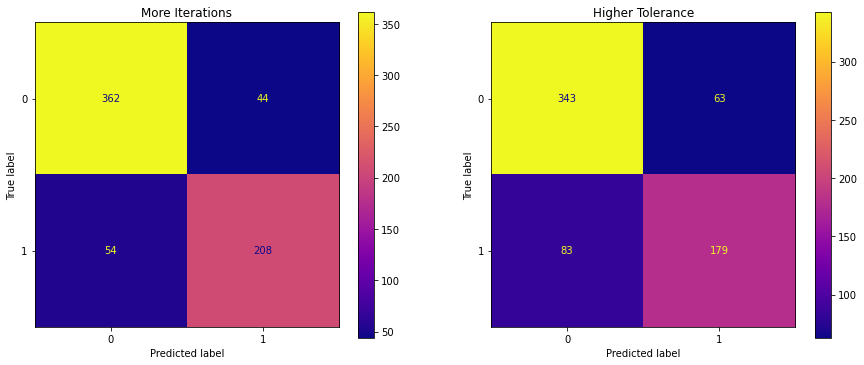

In [726]:
fix, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))

axes[0].set_title("More Iterations")
axes[1].set_title("Higher Tolerance")

plot_confusion_matrix(logreg_model_more_iterations, X_train_imputed, y_train,
                      ax=axes[0], cmap="plasma")
plot_confusion_matrix(logreg_model_higher_tolerance, X_train_imputed, y_train,
                      ax=axes[1], cmap="plasma");

In [727]:
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [728]:
logreg_model_more_iterations_results = ModelWithCV(
                                        logreg_model_more_iterations,
                                        'more_iterations',
                                        X_train_imputed,
                                        y_train
)
    
logreg_model_higher_tolerance_results = ModelWithCV(
                                        logreg_model_higher_tolerance,
                                        'higher_tolerance',
                                        X_train_imputed,
                                        y_train
)

model_results = [
    logreg_model_more_iterations_results,
    logreg_model_higher_tolerance_results
]





CV Results for `more_iterations` model:
            0.76805 ± 0.05988 accuracy
        
CV Results for `higher_tolerance` model:
            0.77849 ± 0.07414 accuracy
        


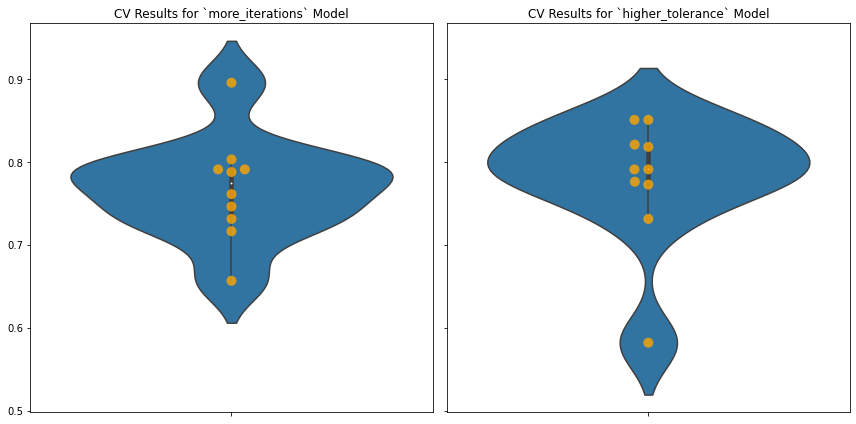

In [729]:
f,axes = plt.subplots(ncols=2, sharey=True, figsize=(12, 6))

for ax, result in zip(axes, model_results):
    ax = result.plot_cv(ax)
    result.print_cv_summary()
plt.tight_layout();

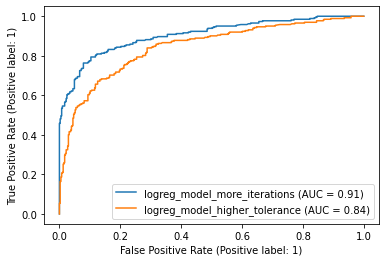

In [730]:
fig, ax = plt.subplots()

plot_roc_curve(logreg_model_more_iterations, X_train_imputed, y_train, 
               name='logreg_model_more_iterations', ax=ax)
plot_roc_curve(logreg_model_higher_tolerance, X_train_imputed, y_train, 
               name='logreg_model_higher_tolerance', ax=ax);

# Even More Data Preparation - Scaling

However, recall we should scale all of the features, so the model isn't overly penalizing age and fare.

In [731]:
#We need to perform Feature Scaling when we are dealing with Gradient Descent Based algorithms (Linear and Logistic Regression, Neural Network) 

scaler = StandardScaler()

scaler.fit(X_train_imputed)

StandardScaler()

In [732]:
def scale_values(X, scaler):
    """
    Given a DataFrame and a fitted scaler, use the scaler to scale all of the features
    """
    scaled_array = scaler.transform(X)
    scaled_df = pd.DataFrame(scaled_array, columns=X.columns, index=X.index)
    return scaled_df

In [733]:
X_train_scaled = scale_values(X_train_imputed, scaler)

In [734]:
X_train_scaled.head()

,Pclass,Age,SibSp,Parch,Fare,female,male,A10,A14,A16,...,E8,F E69,F G63,F G73,F2,F33,F38,F4,G6,T
221,-0.348729,-1.892053e-01,-0.472880,-0.485799,-0.381921,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,...,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.067166,-0.03872,-0.03872,-0.0548,-0.03872
39,0.845891,-1.190445e+00,0.442725,-0.485799,-0.414974,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,...,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.067166,-0.03872,-0.03872,-0.0548,-0.03872
223,0.845891,-5.472489e-16,-0.472880,-0.485799,-0.477873,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,...,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.067166,-0.03872,-0.03872,-0.0548,-0.03872
591,-1.543349,1.736256e+00,0.442725,-0.485799,0.845004,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,...,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.067166,-0.03872,-0.03872,-0.0548,-0.03872
763,-1.543349,5.039607e-01,0.442725,2.010460,1.629533,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,...,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.067166,-0.03872,-0.03872,-0.0548,-0.03872


# 3rd Model - After Scaling

Now that the data is scaled, let's see if we can fit the model without tweaking any hyperparameters.

In [755]:
logreg_model = LogisticRegression(random_state=2022)
logreg_model.fit(X_train_scaled, y_train)

LogisticRegression(random_state=2022)

## Model Evaluation, Part 4

Now that we are able to run a logistic regression with default hyperparameters, let's see how that performs.

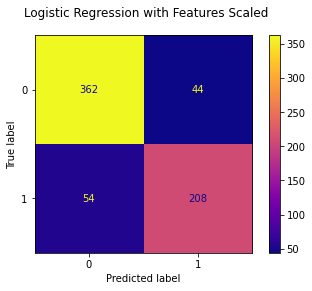

In [756]:
fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with Features Scaled")

plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

In [757]:
scaled_features_results = ModelWithCV(
                            logreg_model,
                            'scaled_features',
                            X_train_scaled,
                            y_train
)

CV Results for `scaled_features` model:
            0.78152 ± 0.05015 accuracy
        


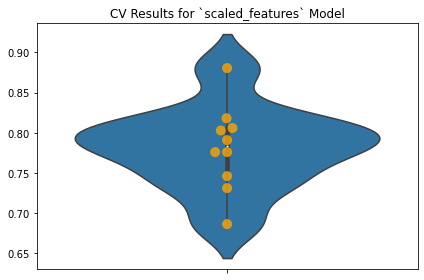

In [758]:
# Saving variable for convenience
model_results = scaled_features_results

# Plot CV results
fig, ax = plt.subplots()
ax = model_results.plot_cv(ax)
plt.tight_layout();
# Print CV results
model_results.print_cv_summary()

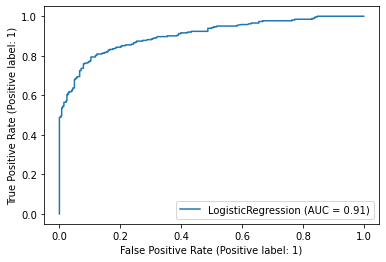

In [759]:
plot_roc_curve(logreg_model, X_train_scaled, y_train)

... this might be overfitting.

## Hyperparameter Adjustment

### Different Regularization Strengths

Let's try out some different regularization penalties to see if we can improve the test data score a bit.

In [752]:
model_results = [scaled_features_results]
C_values = [0.0001, 0.001, 0.01, 0.1, 1]

for c in C_values:
    logreg_model = LogisticRegression(random_state=2022, C=c) #solver = "liblinear"
    logreg_model.fit(X_train_scaled, y_train)
    # Save Results
    new_model_results = ModelWithCV(
                            logreg_model,
                            f'scaled_features_c{c:e}',
                            X_train_scaled,
                            y_train
    )
    model_results.append(new_model_results)
    new_model_results.print_cv_summary()

CV Results for `scaled_features_c1.000000e-04` model:
            0.60778 ± 0.00584 accuracy
        
CV Results for `scaled_features_c1.000000e-03` model:
            0.70513 ± 0.03921 accuracy
        
CV Results for `scaled_features_c1.000000e-02` model:
            0.79493 ± 0.07027 accuracy
        
CV Results for `scaled_features_c1.000000e-01` model:
            0.78747 ± 0.05356 accuracy
        
CV Results for `scaled_features_c1.000000e+00` model:
            0.78152 ± 0.05015 accuracy
        


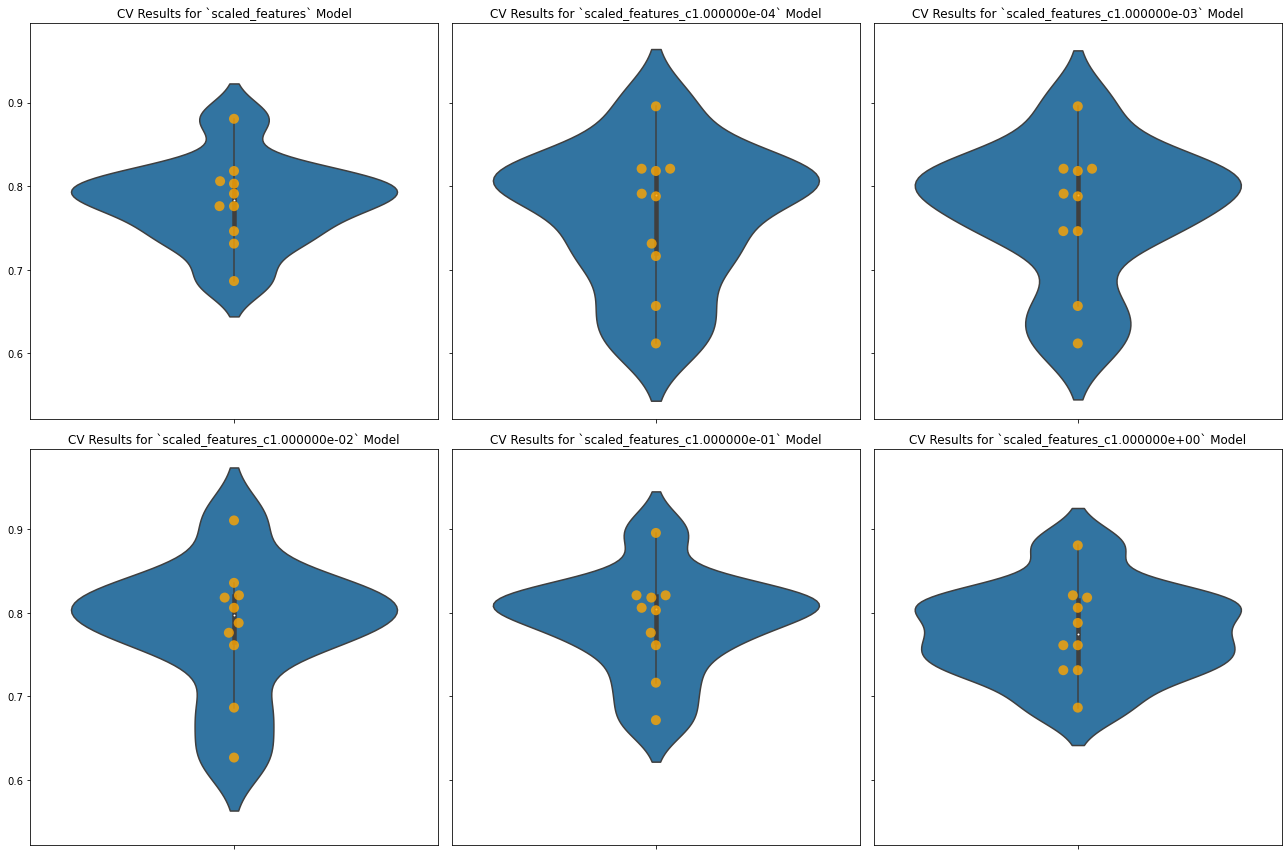

In [640]:
f,axes = plt.subplots(ncols=3, nrows=2, sharey='all', figsize=(18, 12))

for ax,result in zip(axes.ravel(),model_results):
    ax = result.plot_cv(ax)

plt.tight_layout();

It looks like the C = .1 value is pretty optimal for this solver.

In [641]:
model_results = [scaled_features_results]
scaled_features_cross_val_score = scaled_features_results.cv_results

### Different Solvers

In [642]:
logreg_model = LogisticRegression(random_state=2022, C=0.1)
logreg_model.fit(X_train_scaled, y_train)
ModelWithCV(logreg_model, "l2", X_train_scaled, y_train).print_cv_summary()

CV Results for `l2` model:
            0.78747 ± 0.05356 accuracy
        


In [643]:
logreg_model = LogisticRegression(random_state=2022, solver="liblinear", C=0.1)
logreg_model.fit(X_train_scaled, y_train)
ModelWithCV(logreg_model, "l2", X_train_scaled, y_train).print_cv_summary()


CV Results for `l2` model:
            0.78899 ± 0.05891 accuracy
        


In [644]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        logreg_model, 
        'solver:liblinear_C:0.1',
        X_train_scaled,
        y_train
    )
)

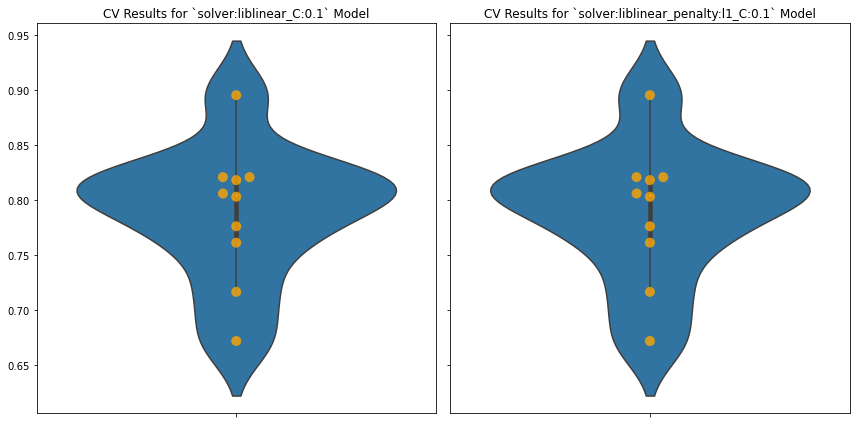

In [695]:
# Save for later comparison
model_results.append(
    ModelWithCV(
        logreg_model, 
        'solver:liblinear_penalty:l1_C:0.1',
        X_train_scaled,
        y_train
    )
)

# Plot both  models
f,axes = plt.subplots(ncols=2, sharey='all', figsize=(12, 6))

model_results[1].plot_cv(ax=axes[0])
model_results[-1].plot_cv(ax=axes[1])

plt.tight_layout();

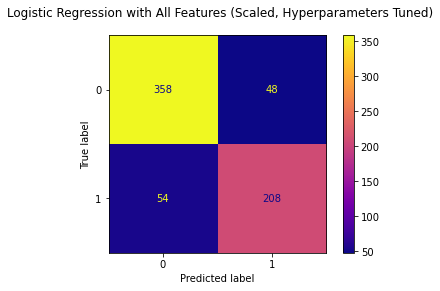

In [670]:
logreg_model = LogisticRegression(random_state=2022, solver="liblinear", C =.1)
logreg_model.fit(X_train_scaled, y_train)

fig, ax = plt.subplots()

fig.suptitle("Logistic Regression with All Features (Scaled, Hyperparameters Tuned)")

plot_confusion_matrix(logreg_model, X_train_scaled, y_train, ax=ax, cmap="plasma");

## `SelectFromModel`

The last model is probably overfitting. We might try thinning out the number of features by eliminating the ones with small modeling coefficients using [`SelectFromModel`](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.SelectFromModel.html)

In [671]:
selector = SelectFromModel(logreg_model)

selector.fit(X_train_scaled, y_train)

SelectFromModel(estimator=LogisticRegression(C=0.1, random_state=2022,
                                             solver='liblinear'))

We're using the default threshold here:

In [672]:
thresh = selector.threshold_
thresh

0.11543751272608135

Let's get a sense of which features will be eliminated:

In [673]:
coefs = selector.estimator_.coef_
coefs

array([[-0.54450077, -0.45884731, -0.39174566,  0.03248606,  0.36799986,
         0.57420936, -0.57420936, -0.11061179, -0.11985897,  0.08239924,
        -0.11453391,  0.14512745,  0.17285215,  0.13070636,  0.08510492,
        -0.09950322, -0.07474856,  0.11789107, -0.08851698,  0.04704331,
        -0.10925737,  0.0834803 , -0.08415097,  0.05571378, -0.07390712,
         0.06018274,  0.04580523, -0.08681472,  0.07353175, -0.08635778,
        -0.09869119,  0.05172077,  0.0537736 ,  0.05257374,  0.05037541,
         0.12279738, -0.0701106 ,  0.05382993, -0.12813823,  0.07594175,
         0.05282175,  0.05576509,  0.05231246,  0.04497908,  0.06535024,
        -0.10818511, -0.13128775, -0.09849232, -0.23759889,  0.09367624,
         0.08446635,  0.12028325, -0.10171314, -0.11432478, -0.03973882,
        -0.09857168,  0.06543376, -0.11637184,  0.11698783,  0.05788229,
        -0.21290372, -0.0779645 , -0.08946679,  0.05135196,  0.04182795,
        -0.1079603 , -0.16619824,  0.07258689,  0.1

In [674]:
coefs.shape

(1, 129)

In [675]:
coefs[coefs > thresh].shape

(28,)

In [676]:
selector.get_support()

array([ True,  True,  True, False,  True,  True,  True, False,  True,
       False, False,  True,  True,  True, False, False, False,  True,
       False, False, False, False, False, False, False, False, False,
       False, False, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False, False, False,
       False,  True, False,  True, False, False,  True, False, False,
       False, False, False,  True,  True, False,  True, False, False,
       False, False, False,  True, False,  True, False,  True, False,
       False, False, False,  True, False, False, False,  True,  True,
        True,  True, False, False, False, False, False,  True, False,
       False, False, False,  True,  True,  True, False,  True, False,
       False,  True,  True, False,  True,  True,  True,  True,  True,
        True,  True, False, False, False, False, False, False,  True,
       False, False,  True, False, False, False, False,  True, False,
        True,  True,

In [677]:
dict(zip(X_train_scaled.columns, selector.get_support()))

{'Pclass': True,
 'Age': True,
 'SibSp': True,
 'Parch': False,
 'Fare': True,
 'female': True,
 'male': True,
 'A10': False,
 'A14': True,
 'A16': False,
 'A19': False,
 'A20': True,
 'A23': True,
 'A31': True,
 'A34': False,
 'A36': False,
 'A5': False,
 'A6': True,
 'A7': False,
 'B101': False,
 'B102': False,
 'B18': False,
 'B19': False,
 'B20': False,
 'B22': False,
 'B28': False,
 'B3': False,
 'B30': False,
 'B35': False,
 'B37': False,
 'B38': False,
 'B39': False,
 'B42': False,
 'B49': False,
 'B5': False,
 'B50': True,
 'B51 B53 B55': False,
 'B57 B59 B63 B66': False,
 'B58 B60': True,
 'B69': False,
 'B73': False,
 'B77': False,
 'B78': False,
 'B79': False,
 'B80': False,
 'B82 B84': False,
 'B86': True,
 'B94': False,
 'B96 B98': True,
 'C101': False,
 'C103': False,
 'C106': True,
 'C110': False,
 'C111': False,
 'C123': False,
 'C124': False,
 'C126': False,
 'C128': True,
 'C148': True,
 'C2': False,
 'C22 C26': True,
 'C23 C25 C27': False,
 'C30': False,
 'C32': Fals

In [678]:
def select_important_features(X, selector):
    """
    Given a DataFrame and a selector, use the selector to choose
    the most important columns
    """
    imps = dict(zip(X.columns, selector.get_support()))
    selected_array = selector.transform(X)
    selected_df = pd.DataFrame(selected_array,
                               columns=[col for col in X.columns if imps[col]],
                               index=X.index)
    return selected_df

In [679]:
X_train_selected = select_important_features(X=X_train_scaled, selector=selector)

In [680]:
X_train_selected.head()

,Pclass,Age,SibSp,Fare,female,male,A14,A20,A23,A31,...,E12,E121,E17,E24,E25,E50,E8,F33,F4,G6
221,-0.348729,-1.892053e-01,-0.472880,-0.381921,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
39,0.845891,-1.190445e+00,0.442725,-0.414974,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
223,0.845891,-5.472489e-16,-0.472880,-0.477873,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
591,-1.543349,1.736256e+00,0.442725,0.845004,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
763,-1.543349,5.039607e-01,0.442725,1.629533,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548


In [681]:
logreg_sel = LogisticRegression(random_state=2022, solver="liblinear", C =.01)

logreg_sel.fit(X_train_selected, y_train)

LogisticRegression(C=0.01, random_state=2022, solver='liblinear')

Probably still overfitting, but let's call this our final model!

# Final Model Evaluation

Now that we have a final model, run X_test through all of the preprocessing steps so we can evaluate the model's performance

In [682]:
X_test_no_transformations = X_test.copy()

In [683]:

# separate out values for imputation
X_test_numeric = X_test_no_transformations[numeric_feature_names]
X_test_categorical = X_test_no_transformations[categorical_feature_names]

In [684]:
# impute missing values
X_test_numeric = impute_missing_values(X_test_numeric, numeric_imputer)
X_test_categorical = impute_missing_values(X_test_categorical, categorical_imputer)
X_test_final = pd.concat([X_test_numeric, X_test_categorical], axis=1)


In [685]:
# one-hot encode categorical data
for categorical_feature in categorical_feature_names:
    X_test_final = encode_and_concat_feature(X_test_final,
                                       categorical_feature, encoders[categorical_feature])

In [686]:
# scale values
X_test_scaled = scale_values(X_test_final, scaler)

In [687]:
# select features
X_test_selected = select_important_features(X_test_scaled, selector)

In [688]:
X_test_selected.head()

,Pclass,Age,SibSp,Fare,female,male,A14,A20,A23,A31,...,E12,E121,E17,E24,E25,E50,E8,F33,F4,G6
770,0.845891,-4.202606e-01,-0.472880,-0.447716,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
178,-0.348729,4.185004e-02,-0.472880,-0.381921,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
786,0.845891,-8.823712e-01,-0.472880,-0.485392,1.344144,-1.344144,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
159,0.845891,-5.472489e-16,6.851964,0.681142,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548
656,0.845891,-5.472489e-16,-0.472880,-0.477873,-0.743968,0.743968,-0.03872,-0.03872,-0.03872,-0.03872,...,-0.03872,-0.0548,-0.03872,-0.0548,-0.03872,-0.03872,-0.0548,-0.067166,-0.03872,-0.0548


Create a model with the relevant hyperparameters, fit, and score

In [689]:
final_model = LogisticRegression(random_state=2022, solver="liblinear", C =.1)
final_model.fit(X_train_selected, y_train)

final_model.score(X_test_selected, y_test)

0.7982062780269058

## Compare the past models

In [690]:
# Create a way to categorize our different models
model_candidates = [
  
    {
        'name':'logreg_model_more_iterations'
        ,'model':logreg_model_more_iterations
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'logreg_model_higher_tolerance'
        ,'model':logreg_model_higher_tolerance
        ,'X_test':X_test_final
        ,'y_test':y_test
    },
    {
        'name':'final_model'
        ,'model':final_model
        ,'X_test':X_test_selected
        ,'y_test':y_test
    }
]

In [691]:
final_scores_dict = {
    "Model Name": [candidate.get('name') for candidate in model_candidates],
    "Mean Accuracy": [
        candidate.get('model').score(
                                candidate.get('X_test'), 
                                candidate.get('y_test')
        ) 
        for candidate in model_candidates
    ]
    
}
final_scores_df = pd.DataFrame(final_scores_dict).set_index('Model Name')
final_scores_df

,Mean Accuracy
Model Name,
logreg_model_more_iterations,0.766816
logreg_model_higher_tolerance,0.811659
final_model,0.798206


Final comparison of confusion matrices

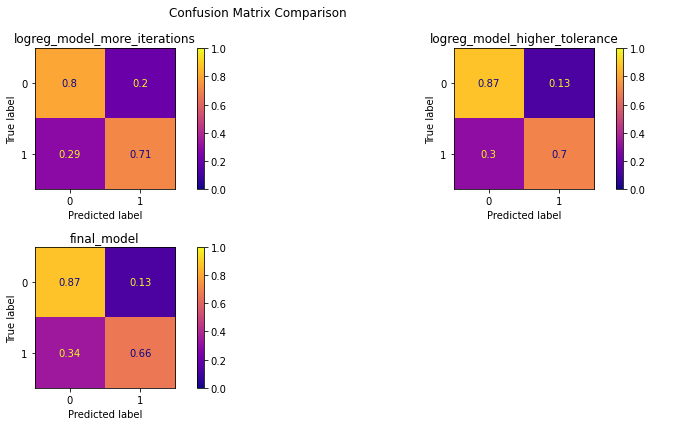

In [692]:
nrows = 2
ncols = math.ceil(len(model_candidates)/nrows)

fig, axes = plt.subplots(
                nrows=nrows,
                ncols=ncols,
                figsize=(12, 6)
)
fig.suptitle("Confusion Matrix Comparison")

# Turn off all the axes (in case nothing to plot); turn on while iterating over
[ax.axis('off') for ax in axes.ravel()]


for i,candidate in enumerate(model_candidates):
    # Logic for making rows and columns for matrices
    row = i // 2
    col = i % 2
    ax = axes[row][col]
    
    ax.set_title(candidate.get('name'))
    ax.set_axis_on() 
    cm_display = plot_confusion_matrix(
                    candidate.get('model'),
                    candidate.get('X_test'),
                    candidate.get('y_test'),
                    normalize='true',
                    cmap='plasma',
                    ax=ax,
                    
    )
    cm_display.im_.set_clim(0, 1)

plt.tight_layout()

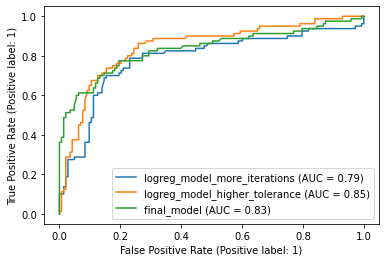

In [693]:
fig, ax = plt.subplots()

# Plot only the last models we created (so it's not too cluttered)
for model_candidate in model_candidates[0:]:
    plot_roc_curve(
        model_candidate.get('model'),
        model_candidate.get('X_test'),
        model_candidate.get('y_test'), 
        name=model_candidate.get('name'),
        ax=ax
    )

# Exercise

Build and iterate on a logistic regression model of **color** for the diamonds dataset! Maximize accuracy.

In [ ]:
diamonds = sns.load_dataset('diamonds')